/tmp/ipykernel_6908/3151092386.py:148: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


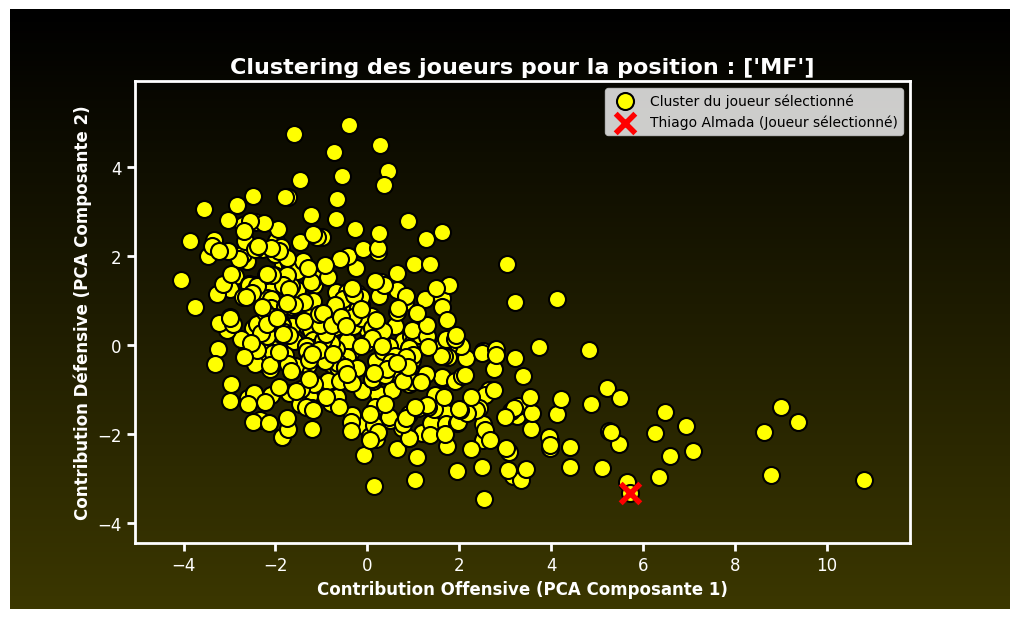

Les 10 joueurs de la même communauté les plus proches de Thiago Almada (du plus proche au plus éloigné) :
Jonas Hofmann - Distance : 0.27
Andrej Kramarić - Distance : 0.73
Luis Guilherme - Distance : 0.85
Nicolás Serrano - Distance : 1.14
Antonio Nusa - Distance : 1.21
James Maddison - Distance : 1.43
Martin Ødegaard - Distance : 1.44
David Brooks - Distance : 1.47
Kiernan Dewsbury-Hall - Distance : 1.48
Julian Brandt - Distance : 1.67

### Contribution Offensive (PCA Composante 1) ###
Contribution Offensive la plus élevée : Kevin De Bruyne, Valeur PCA : 10.813438254359225
Contribution Offensive la plus faible : Kaishu Sano, Valeur PCA : -4.056903297561549

### Contribution Défensive (PCA Composante 2) ###
Contribution Défensive la plus élevée : Casemiro, Valeur PCA : 4.941685917879569
Contribution Défensive la plus faible : Albert Guðmundsson, Valeur PCA : -3.446200062215587


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Function to create gradient background
def create_gradient_background(fig, color1="#000000", color2="#3b3700"):
    """Creates a vertical gradient background for the figure."""
    gradient = np.linspace(0, 1, 256).reshape(-1, 1)
    gradient = np.hstack((gradient, gradient))

    cmap = mcolors.LinearSegmentedColormap.from_list("", [color1, color2])

    # Create an axis that covers the entire figure
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    # Apply the gradient to cover the whole background
    ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 1, 0, 1], zorder=-1)

# Create the directory if it doesn't exist
output_dir = '../../viz_data/thread_001_clustering'
os.makedirs(output_dir, exist_ok=True)

# Charger les données
file_path = '../../data/cleaned_scouting_report.csv'  # Remplacer par le bon chemin
data = pd.read_csv(file_path)

# Sélectionner un joueur par son nom
player_name = "Thiago Almada"  # Remplacer par le nom du joueur
selected_player = data[data['player_name'] == player_name]

# Obtenir la position du joueur
positions = selected_player['Position'].values[0].split(',')  # Diviser en cas de positions multiples

# Vérifier si le joueur a plusieurs positions ou une seule
if len(positions) > 1:
    # Si plusieurs positions, filtrer les joueurs ayant l'une ou l'autre des positions
    position_filter = '|'.join(positions)  # Créer une expression régulière pour capturer toutes les positions
    position_players = data[data['Position'].str.contains(position_filter, na=False)]
else:
    # Si une seule position, filtrer uniquement les joueurs ayant cette position
    position_players = data[data['Position'] == positions[0]]

# Définir les caractéristiques pour Contribution Offensive
offensive_features = [
    'Buts (sans les pénaltys)', 'npxG: xG sans les pénaltys', 'Passes décisives', 
    'xAG: Prévu(s) Buts assistés', 'npxG + xAG', 'Actions menant à un tir', 
    'Total des tirs', 'Passes progressives', 'Possessions progressives', 'Dribbles réussis'
]

# Définir les caractéristiques pour Contribution Défensive
defensive_features = [
    'Tacles', 'Interceptions', 'Balles contrées', 'Dégagements', 'Duel aérien gagnés'
]

# Filtrer le dataset pour ne garder que ces caractéristiques
position_players = position_players.dropna(subset=offensive_features + defensive_features)

# Standardiser les caractéristiques offensives et défensives séparément
scaler_offensive = StandardScaler()
scaler_defensive = StandardScaler()

offensive_scaled = scaler_offensive.fit_transform(position_players[offensive_features])
defensive_scaled = scaler_defensive.fit_transform(position_players[defensive_features])

# PCA pour les variables offensives
pca_offensive = PCA(n_components=1)  # On ne veut qu'une composante principale ici
offensive_component = pca_offensive.fit_transform(offensive_scaled)

# PCA pour les variables défensives
pca_defensive = PCA(n_components=1)  # On ne veut qu'une composante principale ici
defensive_component = pca_defensive.fit_transform(defensive_scaled)

# Combiner les deux composantes dans un seul DataFrame
position_players['PCA_Component_1'] = offensive_component.flatten()  # Contribution offensive
position_players['PCA_Component_2'] = defensive_component.flatten()  # Contribution défensive

# Effectuer le clustering avec KMeans
kmeans = KMeans(n_clusters=3)  # Ajuster le nombre de clusters si nécessaire
position_players['cluster'] = kmeans.fit_predict(np.column_stack([offensive_component, defensive_component]))

# Obtenir les coordonnées PCA du joueur sélectionné
selected_player_pca = position_players[position_players['player_name'] == player_name][['PCA_Component_1', 'PCA_Component_2']].values

# Calculer la distance entre le joueur sélectionné et tous les autres joueurs
distances = cdist(selected_player_pca, position_players[['PCA_Component_1', 'PCA_Component_2']].values, metric='euclidean').flatten()

# Ajouter les distances dans le DataFrame
position_players['distance_to_selected'] = distances

# Trier les joueurs par distance au joueur sélectionné
sorted_players = position_players.sort_values(by='distance_to_selected')

# Tracer les clusters avec un fond en dégradé
fig = plt.figure(figsize=(10, 6))

# Appel de la fonction pour créer le fond en dégradé
create_gradient_background(fig, color1="#000000", color2="#3b3700")

# Tracer les clusters dans l'axe principal
ax = fig.add_subplot(111, facecolor='none')

# Utilisation de couleurs très vives pour que les points se démarquent
# Nous appliquons des bords noirs à chaque point pour les rendre plus visibles
scatter = ax.scatter(
    position_players['PCA_Component_1'], 
    position_players['PCA_Component_2'], 
    c=position_players['cluster'], 
    s=100, 
    cmap='rainbow', 
    edgecolor='black', 
    linewidth=1.5
)

# Texte en blanc et gras pour le titre et les axes
ax.set_title(f'Clustering des joueurs pour la position : {positions}', fontsize=16, color='white', fontweight='bold')
ax.set_xlabel('Contribution Offensive (PCA Composante 1)', fontsize=12, color='white', fontweight='bold')
ax.set_ylabel('Contribution Défensive (PCA Composante 2)', fontsize=12, color='white', fontweight='bold')

# Ajuster automatiquement les limites des axes en fonction des données
x_min, x_max = np.min(position_players['PCA_Component_1']) - 1, np.max(position_players['PCA_Component_1']) + 1
y_min, y_max = np.min(position_players['PCA_Component_2']) - 1, np.max(position_players['PCA_Component_2']) + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Mettre en évidence le cluster du joueur sélectionné
selected_cluster = position_players[position_players['player_name'] == player_name]['cluster'].values[0]
selected_cluster_points = position_players[position_players['cluster'] == selected_cluster][['PCA_Component_1', 'PCA_Component_2']].values

# Encadrer la communauté/cluster
ax.scatter(
    selected_cluster_points[:, 0], 
    selected_cluster_points[:, 1], 
    color='yellow', 
    edgecolor='black', 
    linewidth=1.5, 
    s=150, 
    label='Cluster du joueur sélectionné'
)

# Montrer où se trouve le joueur sélectionné dans son cluster avec une croix plus épaisse
ax.scatter(
    selected_player_pca[0, 0], 
    selected_player_pca[0, 1], 
    color='red', 
    marker='x', 
    s=200, 
    label=f'{player_name} (Joueur sélectionné)', 
    zorder=5,
    linewidth=4,  # Increase the linewidth for the "x" marker
    edgecolors='black'
)

# Ajouter la légende avec texte en blanc
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')

# Mettre les graduations des axes en blanc et en gras
ax.tick_params(axis='x', colors='white', labelsize=12, width=2, length=6)
ax.tick_params(axis='y', colors='white', labelsize=12, width=2, length=6)

# Contour blanc autour du graphique
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    spine.set_linewidth(2)

# Sauvegarder le graphique
plt.savefig(f"{output_dir}/thread_001_clustering.png", dpi=300, bbox_inches='tight')

# Afficher le graphique
plt.show()

# Filtrer les joueurs du même cluster (communauté) que le joueur sélectionné
players_in_same_cluster = sorted_players[sorted_players['cluster'] == selected_cluster]

# Imprimer les 10 premiers joueurs dans l'ordre des plus proches au plus éloigné au sein de la même communauté
print(f"Les 10 joueurs de la même communauté les plus proches de {player_name} (du plus proche au plus éloigné) :")
i = 0
for idx, row in players_in_same_cluster.iterrows():
    if i == 10:
        break
    if player_name != row['player_name']:
        print(f"{row['player_name']} - Distance : {row['distance_to_selected']:.2f}")
        i = i+1

# Extrêmes pour Progression par la passe (PCA Composante 1)
max_offensive = position_players.loc[position_players['PCA_Component_1'].idxmax()]
min_offensive = position_players.loc[position_players['PCA_Component_1'].idxmin()]

print("\n### Contribution Offensive (PCA Composante 1) ###")
print(f"Contribution Offensive la plus élevée : {max_offensive['player_name']}, Valeur PCA : {max_offensive['PCA_Component_1']}")
print(f"Contribution Offensive la plus faible : {min_offensive['player_name']}, Valeur PCA : {min_offensive['PCA_Component_1']}")

# Extrêmes pour la Défense (PCA Composante 2)
max_defensive = position_players.loc[position_players['PCA_Component_2'].idxmax()]
min_defensive = position_players.loc[position_players['PCA_Component_2'].idxmin()]

print("\n### Contribution Défensive (PCA Composante 2) ###")
print(f"Contribution Défensive la plus élevée : {max_defensive['player_name']}, Valeur PCA : {max_defensive['PCA_Component_2']}")
print(f"Contribution Défensive la plus faible : {min_defensive['player_name']}, Valeur PCA : {min_defensive['PCA_Component_2']}")


/tmp/ipykernel_7777/120666556.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_players['PCA_Component_1'] = pca_components[:, 0]
/tmp/ipykernel_7777/120666556.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_players['PCA_Component_2'] = pca_components[:, 1]


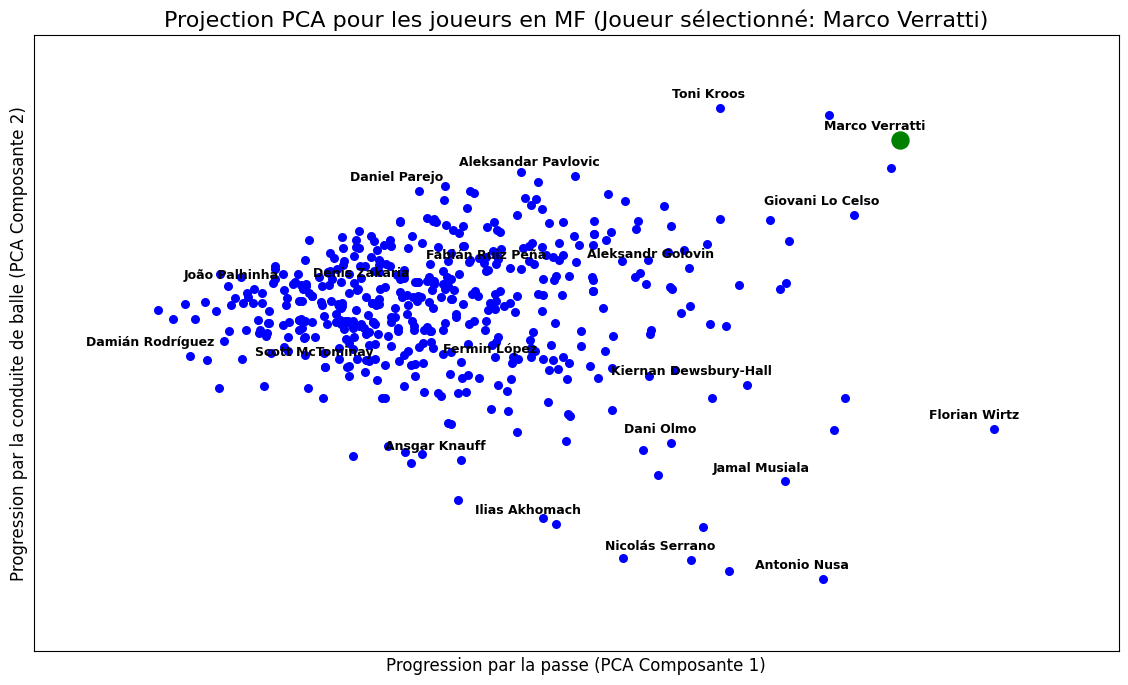


### Extrêmes pour Progression par la passe ###
Progression par la passe la plus élevée : Florian Wirtz, Valeur PCA : 4.413860657865829
Progression par la passe la plus faible : Kaishu Sano, Valeur PCA : -2.2975387941933727

### Extrêmes pour la Progression par la conduite de balle ###
Progression par la conduite de balle la plus élevée : Toni Kroos, Valeur PCA : 2.7826028444956585
Progression par la conduite de balle la plus faible : Antonio Nusa, Valeur PCA : -3.75122322097733


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Charger les données
file_path = '../../data/cleaned_scouting_report.csv'  # Remplacer par le bon chemin
data = pd.read_csv(file_path)

# Sélectionner un joueur par son nom
player_name = "Marco Verratti"  # Remplacer par le nom du joueur
selected_player = data[data['player_name'] == player_name]

# Obtenir la position du joueur
positions = selected_player['Position'].values[0].split(',')  # Diviser en cas de positions multiples

# Vérifier si le joueur a plusieurs positions ou une seule
if len(positions) > 1:
    # Si plusieurs positions, filtrer les joueurs ayant l'une ou l'autre des positions
    position_filter = '|'.join(positions)  # Créer une expression régulière pour capturer toutes les positions
    position_players = data[data['Position'].str.contains(position_filter, na=False)]
else:
    # Si une seule position, filtrer uniquement les joueurs ayant cette position
    position_players = data[data['Position'] == positions[0]]

# Définir les caractéristiques pour Contribution Offensive et Défensive
offensive_features = [
    'Passes progressives'
]
defensive_features = [
    'Possessions progressives'
]

# Combiner les deux ensembles de caractéristiques
all_features = offensive_features + defensive_features

# Filtrer le dataset pour ne garder que ces caractéristiques
features = position_players[all_features].dropna()

# Standardiser les caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Ajouter les composantes PCA au DataFrame pour référence
position_players['PCA_Component_1'] = pca_components[:, 0]
position_players['PCA_Component_2'] = pca_components[:, 1]

# Obtenir les coordonnées PCA du joueur sélectionné
selected_player_pca = pca_components[position_players['player_name'] == player_name]

# Calculer la distance entre tous les points
threshold_distance = 1  # Seuil pour l'affichage des noms
displayed_names = []

# Tracer les joueurs avec des points plus petits et sans les clusters ni légendes, avec une taille de figure plus grande
plt.figure(figsize=(14, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], color='blue', s=30)  # Taille des points réduite

# Mettre en évidence le joueur sélectionné avec un gros point vert
plt.scatter(selected_player_pca[0, 0], selected_player_pca[0, 1], color='green', s=150, zorder=5)  # Taille réduite

# Afficher le nom de chaque joueur uniquement si les points sont suffisamment éloignés les uns des autres
for i, row in position_players.iterrows():
    name = row['player_name']
    x, y = row['PCA_Component_1'], row['PCA_Component_2']
    
    # Vérifier la distance entre ce point et tous les points déjà affichés
    too_close = False
    for x_disp, y_disp in displayed_names:
        if np.linalg.norm([x - x_disp, y - y_disp]) < threshold_distance:
            too_close = True
            break
    
    # Si aucun point trop proche, afficher le nom en gras
    if not too_close or player_name == name:
        plt.text(x+0.2, y+0.1, name, fontsize=9, ha='right', va='bottom', fontweight='bold')  # Texte en gras
        displayed_names.append((x, y))

# Ajouter un titre personnalisé
plt.title(f'Projection PCA pour les joueurs en {positions[0]} (Joueur sélectionné: {player_name})', fontsize=16)

# Ajouter des légendes pour les axes
plt.xlabel('Progression par la passe (PCA Composante 1)', fontsize=12)
plt.ylabel('Progression par la conduite de balle (PCA Composante 2)', fontsize=12)

# Ajuster automatiquement les limites des axes en fonction des données
x_min, x_max = np.min(pca_components[:, 0]) - 1, np.max(pca_components[:, 0]) + 1
y_min, y_max = np.min(pca_components[:, 1]) - 1, np.max(pca_components[:, 1]) + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Enlever les légendes des ticks des axes
plt.xticks([])
plt.yticks([])
plt.show()

# Afficher les extrêmes de la Contribution Offensive et Défensive

# Extrêmes pour Progression par la passe (PCA Composante 1)
max_offensive = position_players.loc[position_players['PCA_Component_1'].idxmax()]
min_offensive = position_players.loc[position_players['PCA_Component_1'].idxmin()]

print("\n### Extrêmes pour Progression par la passe ###")
print(f"Progression par la passe la plus élevée : {max_offensive['player_name']}, Valeur PCA : {max_offensive['PCA_Component_1']}")
print(f"Progression par la passe la plus faible : {min_offensive['player_name']}, Valeur PCA : {min_offensive['PCA_Component_1']}")

# Extrêmes pour la Progression par la conduite de balle (PCA Composante 2)
max_defensive = position_players.loc[position_players['PCA_Component_2'].idxmax()]
min_defensive = position_players.loc[position_players['PCA_Component_2'].idxmin()]

print("\n### Extrêmes pour la Progression par la conduite de balle ###")
print(f"Progression par la conduite de balle la plus élevée : {max_defensive['player_name']}, Valeur PCA : {max_defensive['PCA_Component_2']}")
print(f"Progression par la conduite de balle la plus faible : {min_defensive['player_name']}, Valeur PCA : {min_defensive['PCA_Component_2']}")


ValueError: Single argument to subplot must be a three-digit integer, not 1

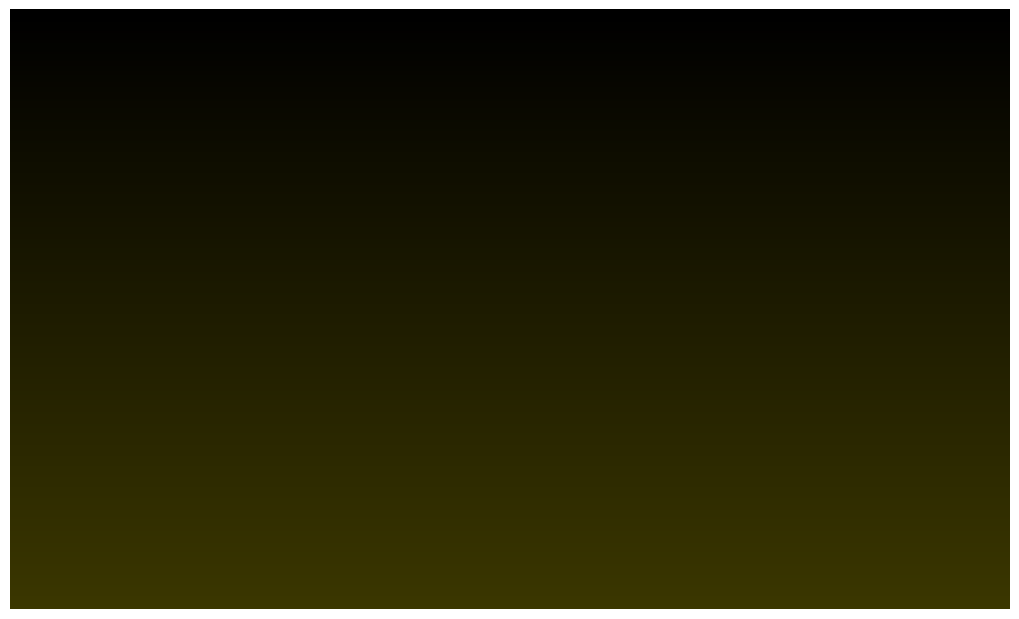

In [8]:
# List of specific players to highlight as "Les sosies de Zlatan"
zlatan_sosies = ["Rayan Cherki"]

# Retrieve the PCA coordinates for the "Les sosies de Zlatan"
zlatan_sosies_pca = position_players[position_players['player_name'].isin(zlatan_sosies)][['PCA_Component_1', 'PCA_Component_2']].values

# Plot the clusters with the gradient background
fig = plt.figure(figsize=(10, 6))

# Create the gradient background
create_gradient_background(fig, color1="#000000", color2="#3b3700")

# Main axis for the plot
ax = fig.add_subplot(111, facecolor='none')

# Plot clusters
scatter = ax.scatter(
    position_players['PCA_Component_1'], 
    position_players['PCA_Component_2'], 
    c=position_players['cluster'], 
    s=100, 
    cmap='rainbow', 
    edgecolor='black', 
    linewidth=1.5
)

# Set title and labels
ax.set_title(f'Comparaison entre Rayan Cherki et Thiago Almada', fontsize=16, color='white', fontweight='bold')
ax.set_xlabel('Contribution Offensive (PCA Composante 1)', fontsize=12, color='white', fontweight='bold')
ax.set_ylabel('Contribution Défensive (PCA Composante 2)', fontsize=12, color='white', fontweight='bold')

# Set limits for the axes
x_min, x_max = np.min(position_players['PCA_Component_1']) - 1, np.max(position_players['PCA_Component_1']) + 1
y_min, y_max = np.min(position_players['PCA_Component_2']) - 1, np.max(position_players['PCA_Component_2']) + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Highlight the cluster of the selected player
selected_cluster = position_players[position_players['player_name'] == player_name]['cluster'].values[0]
selected_cluster_points = position_players[position_players['cluster'] == selected_cluster][['PCA_Component_1', 'PCA_Component_2']].values

# Highlight the selected player with a red cross (X)
ax.scatter(
    selected_player_pca[0, 0], 
    selected_player_pca[0, 1], 
    color='red', 
    marker='x', 
    s=200, 
    label=f'{player_name} (Joueur sélectionné)', 
    zorder=5,
    linewidth=4,  # Increase the linewidth for the "x" marker
    edgecolors='black'
)

# Highlight the "Les sosies de Zlatan" players with red points
ax.scatter(
    zlatan_sosies_pca[:, 0], 
    zlatan_sosies_pca[:, 1], 
    color='red', 
    edgecolor='black', 
    linewidth=1.5, 
    s=150, 
    label='Rayan Cherki', 
    zorder=4
)

# Add legend with white text
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')

# Set ticks and axis styles
ax.tick_params(axis='x', colors='white', labelsize=12, width=2, length=6)
ax.tick_params(axis='y', colors='white', labelsize=12, width=2, length=6)

# Set white borders around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    spine.set_linewidth(2)

# Save the plot
plt.savefig(f"{output_dir}/thread_001_clustering.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

